# DCGAN 작성

## 5.1 학습목표
1. Generator가 화상을 생성하기 위해 어떠한 신경망 구조를 하고 있는지 이해한다
2. Discriminator가 화상을 식별하기 위해 어떤 신경망 구조를 하고 있는지 이해한다
3. GAN의 일반적인 손실함수의 형태와 신경망의 학습 흐름을 이해한다
4. DCGAN 네트워크를 구현할 수 있다

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [3]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 전치 합성곱의 예

In [15]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("입력 데이터")
print(input)
print("-----")

print("일반 합성곱")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
# m.weight[0, 0, 0, 0] = 1
# m.weight[0, 0, 0, 1] = 2
# m.weight[0, 0, 1, 0] = 3
# m.weight[0, 0, 1, 1] = 4
print("커널")
print(m.weight)
print("출력")
print(m(input))

print("-----")
print("전치 합성곱")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
# m.weight[0, 0, 0, 0] = 1
# m.weight[0, 0, 0, 1] = 2
# m.weight[0, 0, 1, 0] = 3
# m.weight[0, 0, 1, 1] = 4
print("커널")
print(m.weight)
print("출력")
print(m(input))


입력 데이터
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
일반 합성곱
커널
Parameter containing:
tensor([[[[0.3839, 0.3083],
          [0.2528, 0.3988]]]], requires_grad=True)
출력
tensor([[[[1.9954]]]], grad_fn=<ConvolutionBackward0>)
-----
전치 합성곱
커널
Parameter containing:
tensor([[[[ 0.1839,  0.2658],
          [ 0.4149, -0.1007]]]], requires_grad=True)
출력
tensor([[[[ 0.1839,  0.4497,  0.2658],
          [ 0.7826,  1.2136,  0.4309],
          [ 0.8298,  0.6284, -0.2015]]]], grad_fn=<ConvolutionBackward0>)


# Generator 구현

In [16]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential( 
            nn.ConvTranspose2d(z_dim, image_size * 8, # ConvTranspose2d(in_channels, out_channels, kerenel_size, stride, padding, output_padding , ... , )
                               kernel_size=4, stride=1), # BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out


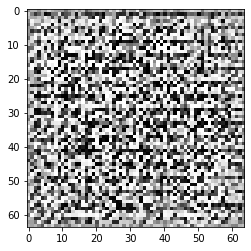

In [17]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminator 구현

- GAN은 사람 대신 G의 화상을 체크하여 숫자 화상으로 보이는지 판정하는 D 신경망을 준비

- 단순한 화상 분류 딥러닝이며 '0': 숫자 화상으로 보이지 않음, '1': 숫자 화상으로 보임이라고 판정

- 초기 단계의 D는 학습하지 않은 신경망이며, 사람이 판단하는 경우와 달리 안이한 판정, G의 생성 화상을 지도 데이터로 잘 못 분류 할 수 있음

- G는 G가 생성한 화상이 실제 필기체 숫자 화상에 가까운 것 같다는 D의 판단으로 비슷한 분위기의 화상을 더 생성하도록 파라미터를 학습

- 미숙한 생기성 G와 미숙한 식별기 D가 서로 속고 속이며 학습을 진행하면서 최종적으로 G와 같은 화상을 생성

In [18]:
# 각 레이어에 합성곱층 Conv2d를 부여함
# Conv2d의 채널 수는 초반 레이어는 적고 뒤의 레이어일수록 많아지도록 함
# 보통의 화상 분류는 합성곱 층 뒤의 활성화 함수에 ReLU를 사용하였지만 GAN에서는 LeakyReLU를 사용함
# 입력 값이 음수일 경우 ReLU는 출력이 0이지만 LeakyReLU를 사용하면 입력값 x 계수 값을 출력함
class Discriminator(nn.Module):
  
    def __init__(self, z_dim = 20, image_size = 64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.1, inplace = True))
        # 주의 : 흑백 화상이므로 입력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size = 4, stride = 1)

    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.last(out)

      return out
      

    

In [19]:
# 동작확인
D = Discriminator(z_dim = 20, image_size = 64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[[[0.4990]]]], grad_fn=<SigmoidBackward0>)


# GAN 손실함수

In [20]:
import cv2
# D의 오차함수의 이미지 구현
# maximize log(D(x)) + log(1 - D(G(z)))

# 정답 라벨 작성
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)
print(label_real)
# 가짜 라벨 작성
label_fake = torch.full((mini_batch_size,), 0)
print(label_fake)
# 오차함수 정의
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')

# 진짜 화상을 판정
d_out_real = D(x)

# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake, view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake

tensor([1, 1])
tensor([0, 0])


NameError: ignored

In [21]:
# G의 오차함수의 이미지 구현
# maximize log(D(G(z)))


# ※ x가 정의되지 않았으므로, 에러가 됩니다
#---------------


# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
g_loss = criterion(d_out_fake.view(-1), label_real)


RuntimeError: ignored

# DataLoader 작성

In [22]:
import os
os.getcwd()

'/content'

In [23]:
%cd "/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/5.  GAN을 활용한 화상 생성"

/content/drive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/5.  GAN을 활용한 화상 생성


In [24]:
def make_datapath_list():
  """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

  train_img_list = list() # 화상 파일 경로를 저장

  for img_idx in range(200):
    img_path = "./data/img_78/img_7_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)

    img_path = "./data/img_78/img_8_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)

  return train_img_list

In [25]:
class ImageTransform():
  """ 화상의 전처리 클래스 """

  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [26]:
class GAN_Img_Dataset(data.Dataset):
  """ 화상의 Dataset 클래스. Pytorch의 Dataset 클래스를 상속"""

  def __init__(self, file_list, transform):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    '''화상 매수를 반환한다'''
    return len(self.file_list)

  def __getitem__(self, index):
    '''전처리한 화상의 Tensor 형식 데이터 취득'''

    img_path = self.file_list[index]
    img = Image.open(img_path) # [높이][폭]흑백

    # 화상 전처리
    img_transformed = self.transform(img)

    return img_transformed

In [27]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성

train_img_list = make_datapath_list()
print(train_img_list)

['./data/img_78/img_7_0.jpg', './data/img_78/img_8_0.jpg', './data/img_78/img_7_1.jpg', './data/img_78/img_8_1.jpg', './data/img_78/img_7_2.jpg', './data/img_78/img_8_2.jpg', './data/img_78/img_7_3.jpg', './data/img_78/img_8_3.jpg', './data/img_78/img_7_4.jpg', './data/img_78/img_8_4.jpg', './data/img_78/img_7_5.jpg', './data/img_78/img_8_5.jpg', './data/img_78/img_7_6.jpg', './data/img_78/img_8_6.jpg', './data/img_78/img_7_7.jpg', './data/img_78/img_8_7.jpg', './data/img_78/img_7_8.jpg', './data/img_78/img_8_8.jpg', './data/img_78/img_7_9.jpg', './data/img_78/img_8_9.jpg', './data/img_78/img_7_10.jpg', './data/img_78/img_8_10.jpg', './data/img_78/img_7_11.jpg', './data/img_78/img_8_11.jpg', './data/img_78/img_7_12.jpg', './data/img_78/img_8_12.jpg', './data/img_78/img_7_13.jpg', './data/img_78/img_8_13.jpg', './data/img_78/img_7_14.jpg', './data/img_78/img_8_14.jpg', './data/img_78/img_7_15.jpg', './data/img_78/img_8_15.jpg', './data/img_78/img_7_16.jpg', './data/img_78/img_8_16.jpg',

In [28]:
# Dataset 작성
mean = (0.5, )
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list = train_img_list, transform = ImageTransform(mean, std)
)

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)

# 동작 확인
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 1 번째 요소를 꺼낸다
print(images.size()) # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


# 학습

In [29]:
# 네트워크 초기화
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    # Conv2d ConvTranspose2d 초기화
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)
  elif classname.find('BatchNorm') != -1:
    # BatchNorm2d 초기화
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)
print("네트워크 초기화 완료")

네트워크 초기화 완료


In [30]:
from torch.nn import BCEWithLogitsLoss

# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1).float(), label_real.float())
            d_loss_fake = criterion(d_out_fake.view(-1).float(), label_fake.float())
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1).float(), label_real.float())

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [31]:
# 학습 및 검증 실행
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader = train_dataloader, num_epochs=num_epochs
)

사용 장치:  cuda:0
-------------
Epoch 0/200
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.0918 ||Epoch_G_Loss:0.1447
timer:  100.3900 sec.
-------------
Epoch 1/200
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.0464 ||Epoch_G_Loss:0.2500
timer:  1.0102 sec.
-------------
Epoch 2/200
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.0922 ||Epoch_G_Loss:0.2874
timer:  0.9700 sec.
-------------
Epoch 3/200
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0318 ||Epoch_G_Loss:0.2881
timer:  0.9717 sec.
-------------
Epoch 4/200
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.0145 ||Epoch_G_Loss:0.7663
timer:  0.9579 sec.
-------------
Epoch 5/200
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.6420 ||Epoch_G_Loss:0.2560
timer:  0.9752 sec.
-------------
Epoch 6/200
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.0090 ||Epoch_G_Loss:0.3325
timer:  0.9622 sec.
-------------
Epoch 7/200
------------

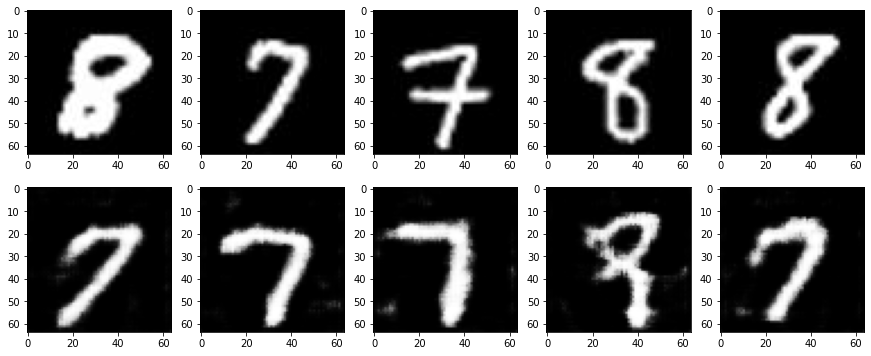

In [32]:
# 생성 화상과 훈련 데이터를 시각화
# 괜찮은 느낌의 화상이 생성될 때까지, 재실행 됨
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 1 번째 요소를 꺼낸다

# 출력
fig = plt.figure(figsize = (15, 6))
for i in range(0, 5):
  # 상단에 훈련 데이터를,
  plt.subplot(2, 5, i + 1)
  plt.imshow(images[i][0].cpu().detach().numpy(), "gray")

  # 하단에 훈련 데이터를 표시
  plt.subplot(2, 5, 5 + i + 1)
  plt.imshow(fake_images[i][0].cpu().detach().numpy(), "gray")